<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FEATURE EXTRACTION**

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

# CONFIGURATION
PATH_A = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/audio_speech_actors_01-24/"
PATH_B = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/Test/"

OUTPUT_PATH = "dual_ravdess_processed_data/"


EMOTION_MAP = {
    1: 0, 2: 0,
    3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6
}

SAMPLE_RATE = 16000
DURATION = 5.0
TOTAL_SAMPLES = int(SAMPLE_RATE * DURATION)

# STFT Specs
N_FFT = 512
WIN_LENGTH = 400
HOP_LENGTH = 160
N_MELS = 60
FMAX = 8000

# CUSTOM IMEL MATH (The Innovation)
def hz_to_imel(freq):
    return 2595 * np.exp(1 + freq / 700.0)

def imel_to_hz(imel):
    return 700 * (np.log(imel / 2595.0) - 1)

def imel_filter_bank(sr, n_fft, n_mels=60, fmin=0.0, fmax=8000):
    """Generates the Inverse-Mel Triangular Filter Bank"""
    imel_min = hz_to_imel(fmin)
    imel_max = hz_to_imel(fmax)

    # Create evenly spaced points in IMel scale
    imel_points = np.linspace(imel_min, imel_max, n_mels + 2)
    hz_points = imel_to_hz(imel_points)

    # Convert to FFT bins
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    filters = np.zeros((n_mels, 1 + n_fft // 2))

    for i in range(n_mels):
        f_m_minus = bin_points[i]
        f_m = bin_points[i+1]
        f_m_plus = bin_points[i+2]

        for k in range(f_m_minus, f_m):
            filters[i, k] = (k - f_m_minus) / (f_m - f_m_minus)
        for k in range(f_m, f_m_plus):
            filters[i, k] = (f_m_plus - k) / (f_m_plus - f_m)

    return filters

# FEATURE EXTRACTOR
def extract_dual_features(audio_path):
    try:
        # 1. Load & Pad
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        if len(y) < TOTAL_SAMPLES:
            y = np.pad(y, (0, TOTAL_SAMPLES - len(y)))
        else:
            y = y[:TOTAL_SAMPLES]

        # 2. Pre-emphasis

        # 3. Power Spectrum
        D = np.abs(librosa.stft(y, n_fft=N_FFT, win_length=WIN_LENGTH, hop_length=HOP_LENGTH))**2

        # 4. Channel A: Mel Spectrogram
        mel_filters = librosa.filters.mel(sr=sr, n_fft=N_FFT, n_mels=N_MELS, fmax=FMAX)
        mel_spec = np.dot(mel_filters, D)
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)

        # 5. Channel B: IMel Spectrogram
        imel_filters = imel_filter_bank(sr, N_FFT, N_MELS, fmax=FMAX)
        imel_spec = np.dot(imel_filters, D)
        log_imel = librosa.power_to_db(imel_spec, ref=np.max)

        TARGET_WIDTH = 504

        def fix_width(spec):
            if spec.shape[1] > TARGET_WIDTH:
                return spec[:, :TARGET_WIDTH]
            else:
                return np.pad(spec, ((0,0), (0, TARGET_WIDTH - spec.shape[1])))

        log_mel = fix_width(log_mel)
        log_imel = fix_width(log_imel)

        return log_mel[..., np.newaxis], log_imel[..., np.newaxis]

    except Exception as e:
        print(f"Error: {e}")
        return None, None

# PROCESSING LOOP (MERGING)
def process_ravdess_unified():
    # Master Lists
    X_mel_all = []
    X_imel_all = []
    Y_all = []
    S_all = [] # Speakers

    paths_to_scan = [PATH_A, PATH_B]

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    print("Starting Dual-Channel Extraction...")

    # Iterate over both directories (Train Folder AND Test Folder)
    for root_path in paths_to_scan:
        if not os.path.exists(root_path):
            print(f"Skipping missing path: {root_path}")
            continue

        # Get Actor Folders
        actor_folders = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

        for actor in tqdm(actor_folders, desc=f"Scanning {os.path.basename(root_path)}"):
            actor_path = os.path.join(root_path, actor)
            files = [f for f in os.listdir(actor_path) if f.endswith('.wav')]

            for file_name in files:
                # Parse Filename: 03-01-06-01-02-01-24.wav
                parts = file_name.split('.')[0].split('-')
                if len(parts) < 7: continue

                emotion_code = int(parts[2])
                speaker_id = parts[6] # '24'

                if emotion_code not in EMOTION_MAP: continue
                label = EMOTION_MAP[emotion_code]

                # Extract
                full_path = os.path.join(actor_path, file_name)
                mel, imel = extract_dual_features(full_path)

                if mel is not None:
                    X_mel_all.append(mel)
                    X_imel_all.append(imel)
                    Y_all.append(label)
                    S_all.append(speaker_id)

    # Convert to Arrays
    print("\nConverting to Numpy Arrays...")
    X_mel_all = np.array(X_mel_all)
    X_imel_all = np.array(X_imel_all)
    Y_all = np.array(Y_all)
    S_all = np.array(S_all)

    X_mel_all = np.nan_to_num(X_mel_all)
    X_imel_all = np.nan_to_num(X_imel_all)

    print(f"\nFinal Dataset Stats:")
    print(f"Mel Shape:  {X_mel_all.shape}")
    print(f"IMel Shape: {X_imel_all.shape}")
    print(f"Labels:     {Y_all.shape}")

    # Save
    print(f"Saving to {OUTPUT_PATH}...")
    np.save(os.path.join(OUTPUT_PATH, "X_mel_all.npy"), X_mel_all)
    np.save(os.path.join(OUTPUT_PATH, "X_imel_all.npy"), X_imel_all)
    np.save(os.path.join(OUTPUT_PATH, "Y_all.npy"), Y_all)
    np.save(os.path.join(OUTPUT_PATH, "S_all.npy"), S_all)
    print("Done.")

if __name__ == "__main__":
    process_ravdess_unified()

Starting Dual-Channel Extraction...


Scanning : 100%|██████████| 2/2 [01:16<00:00, 38.24s/it]



Converting to Numpy Arrays...

Final Dataset Stats:
Mel Shape:  (1440, 60, 504, 1)
IMel Shape: (1440, 60, 504, 1)
Labels:     (1440,)
Saving to dual_ravdess_processed_data/...
Done.


In [ ]:
!zip -r dual_ravdess_processed_data.zip dual_ravdess_processed_data/

  adding: dual_ravdess_processed_data/ (stored 0%)
  adding: dual_ravdess_processed_data/X_mel_all.npy (deflated 58%)
  adding: dual_ravdess_processed_data/Y_all.npy (deflated 91%)
  adding: dual_ravdess_processed_data/S_all.npy (deflated 98%)
  adding: dual_ravdess_processed_data/X_imel_all.npy (deflated 75%)


In [ ]:
!unzip -q dual_ravdess_processed_data.zip -d ./

# **VERFIFICATION**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

DATA_PATH = "dual_ravdess_processed_data/"

print("Loading Unified RAVDESS Data...")
X_mel = np.load(os.path.join(DATA_PATH, "X_mel_all.npy"))
X_imel = np.load(os.path.join(DATA_PATH, "X_imel_all.npy"))
Y = np.load(os.path.join(DATA_PATH, "Y_all.npy"))


X_mel = np.nan_to_num(X_mel, nan=0.0)
X_imel = np.nan_to_num(X_imel, nan=0.0)

print(f"Mel Shape:  {X_mel.shape}")
print(f"IMel Shape: {X_imel.shape}")
print(f"Labels:     {Y.shape}")

# RANDOM SPLIT (70/30)
indices = np.arange(len(Y))
train_idx, test_idx = train_test_split(indices, test_size=0.30, random_state=42, stratify=Y)

# Apply split
X_mel_train, X_mel_test = X_mel[train_idx], X_mel[test_idx]
X_imel_train, X_imel_test = X_imel[train_idx], X_imel[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

print(f"Train Samples: {len(Y_train)}")
print(f"Test Samples:  {len(Y_test)}")


def standardize(train, test):
    scaler = StandardScaler()
    train_flat = train.reshape(train.shape[0], -1)
    test_flat = test.reshape(test.shape[0], -1)

    train_scaled = scaler.fit_transform(train_flat)
    test_scaled = scaler.transform(test_flat)


    return train_scaled.reshape(train.shape), test_scaled.reshape(test.shape)

print("Standardizing Mel features...")
X_mel_train, X_mel_test = standardize(X_mel_train, X_mel_test)

print("Standardizing IMel features...")
X_imel_train, X_imel_test = standardize(X_imel_train, X_imel_test)

# MODEL ARCHITECTURE (Li et al. 2022)
def build_cnn_branch(input_shape, name_prefix):
    """Creates one arm of the Y-network (Table 1)"""
    inputs = layers.Input(shape=input_shape, name=f"{name_prefix}_input")

    x = layers.Conv2D(32, (6,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, (4,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,1))(x)

    x = layers.Conv2D(96, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = layers.GlobalAveragePooling2D()(x)

    return inputs, x

def build_dual_channel_model():
    input_shape = (60, 504, 1)

    in_mel, out_mel = build_cnn_branch(input_shape, "mel")

    in_imel, out_imel = build_cnn_branch(input_shape, "imel")

    concatenated = layers.Concatenate()([out_mel, out_imel]) # (256,)

    # --- SSAE Block (Classifier Mode) ---
    x = layers.Dense(118, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(concatenated)
    x = layers.Dense(108, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(x)
    x = layers.Dense(98, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(x)

    # --- Output ---
    outputs = layers.Dense(7, activation='softmax')(x)

    model = models.Model(inputs=[in_mel, in_imel], outputs=outputs, name="Dual_CNN_SSAE")
    return model

model = build_dual_channel_model()
model.summary()

# TRAIN
optimizer = optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Loading Unified RAVDESS Data...
Mel Shape:  (1440, 60, 504, 1)
IMel Shape: (1440, 60, 504, 1)
Labels:     (1440,)
Train Samples: 1008
Test Samples:  432
Standardizing Mel features...
Standardizing IMel features...


Model: "Dual_CNN_SSAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_input           │ (None, 60, 504,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imel_input          │ (None, 60, 504,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 60, 504,   │        608 │ mel_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 504,   │        608 │ imel_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 504,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 504,   │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 60, 504,   │      8,256 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 504,   │      8,256 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 504,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 504,   │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 504,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 504,   │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 30, 504,   │     55,392 │ max_pooling2d[0]

 Total params: 407,065 (1.55 MB)

 Trainable params: 405,785 (1.55 MB)

 Non-trainable params: 1,280 (5.00 KB)


Starting Verification Training...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.6184 - loss: 1.0149 - val_accuracy: 0.3218 - val_loss: 2.6107
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.6207 - loss: 0.9935 - val_accuracy: 0.3264 - val_loss: 2.0778
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.6406 - loss: 0.9711 - val_accuracy: 0.2153 - val_loss: 4.2261
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.6420 - loss: 1.0069 - val_accuracy: 0.2847 - val_loss: 2.6395
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step - accuracy: 0.5866 - loss: 1.0473 - val_accuracy: 0.2963 - val_loss: 2.4518
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step - accuracy: 0.6495 - loss: 0.9785 - val_accuracy: 0.3310 - val_loss: 2.0434
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - accuracy: 0.6526 - loss: 0.9328 - val_accuracy: 0.1481 - val_loss: 5.1106
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step -

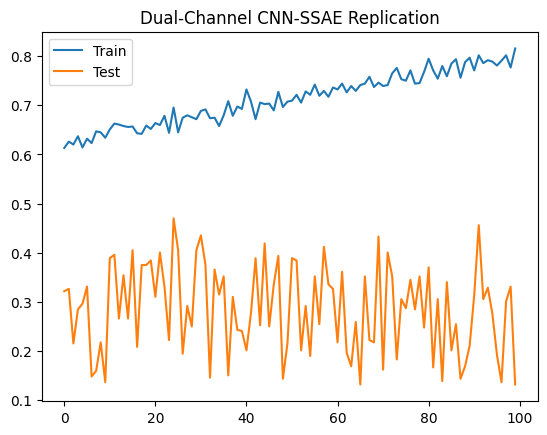

In [ ]:
print("\nStarting Verification Training...")
history = model.fit(
    [X_mel_train, X_imel_train], Y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_mel_test, X_imel_test], Y_test),
    verbose=1
)

# RESULTS
loss, acc = model.evaluate([X_mel_test, X_imel_test], Y_test)
print("\n------------------------------------------------")
print(f"REPLICATION RESULT (RAVDESS 7-Class)")
print(f"Target Accuracy (Paper): ~83.18%")
print(f"Your Accuracy:           {acc*100:.2f}%")
print("------------------------------------------------")

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Dual-Channel CNN-SSAE Replication')
plt.legend()
plt.show()

# **SPEAKER SPLIT**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# LOAD DATA
DATA_PATH = "dual_ravdess_processed_data/"


X_mel = np.load(os.path.join(DATA_PATH, "X_mel_all.npy"))
X_imel = np.load(os.path.join(DATA_PATH, "X_imel_all.npy"))
Y = np.load(os.path.join(DATA_PATH, "Y_all.npy"))
S = np.load(os.path.join(DATA_PATH, "S_all.npy"))


X_mel = np.nan_to_num(X_mel, nan=0.0)
X_imel = np.nan_to_num(X_imel, nan=0.0)

print(f"Total Samples: {len(Y)}")
print(f"Speakers Found: {np.unique(S)}")

# STRICT SPEAKER SPLIT

print("\n--- APPLYING SPEAKER SPLIT ---")
train_mask = S <= '20'
test_mask  = S >= '21'

X_mel_train, X_mel_test = X_mel[train_mask], X_mel[test_mask]
X_imel_train, X_imel_test = X_imel[train_mask], X_imel[test_mask]
Y_train, Y_test = Y[train_mask], Y[test_mask]

# Verification
train_speakers = np.unique(S[train_mask])
test_speakers  = np.unique(S[test_mask])

print(f"Training Speakers: {len(train_speakers)} (01-20)")
print(f"Testing Speakers:  {len(test_speakers)}  (21-24)")
print(f"Train Samples: {len(Y_train)}")
print(f"Test Samples:  {len(Y_test)}")

# Leakage Check
intersection = np.intersect1d(train_speakers, test_speakers)
if len(intersection) > 0:
    raise ValueError(f"CRITICAL ERROR: Data Leakage! Speakers in both sets: {intersection}")

# STANDARDIZATION
def standardize(train, test):
    scaler = StandardScaler()
    train_flat = train.reshape(train.shape[0], -1)
    test_flat = test.reshape(test.shape[0], -1)

    train_scaled = scaler.fit_transform(train_flat)
    test_scaled = scaler.transform(test_flat)


    return train_scaled.reshape(train.shape), test_scaled.reshape(test.shape)

print("\nStandardizing Mel features...")
X_mel_train, X_mel_test = standardize(X_mel_train, X_mel_test)

print("Standardizing IMel features...")
X_imel_train, X_imel_test = standardize(X_imel_train, X_imel_test)

# MODEL ARCHITECTURE
def build_cnn_branch(input_shape, name_prefix):
    """Creates one arm of the Y-network (Table 1)"""
    inputs = layers.Input(shape=input_shape, name=f"{name_prefix}_input")

    x = layers.Conv2D(32, (6,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, (4,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,1))(x)

    x = layers.Conv2D(96, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)

    return inputs, x

def build_dual_channel_model():
    input_shape = (60, 504, 1)

    in_mel, out_mel = build_cnn_branch(input_shape, "mel")

    in_imel, out_imel = build_cnn_branch(input_shape, "imel")

    concatenated = layers.Concatenate()([out_mel, out_imel]) # (256,)

    x = layers.Dense(118, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(concatenated)
    x = layers.Dense(108, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(x)
    x = layers.Dense(98, activation='sigmoid', activity_regularizer=regularizers.l1(1e-5))(x)

    outputs = layers.Dense(7, activation='softmax')(x)

    model = models.Model(inputs=[in_mel, in_imel], outputs=outputs, name="Dual_CNN_SSAE_SpeakerSplit")
    return model

model = build_dual_channel_model()
model.summary()


optimizer = optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Loading Unified RAVDESS Data...
Total Samples: 1440
Speakers Found: ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24']

--- APPLYING SPEAKER SPLIT ---
Training Speakers: 20 (01-20)
Testing Speakers:  4  (21-24)
Train Samples: 1200
Test Samples:  240

Standardizing Mel features...
Standardizing IMel features...


Model: "Dual_CNN_SSAE_SpeakerSplit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_input           │ (None, 60, 504,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imel_input          │ (None, 60, 504,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 60, 504,   │        608 │ mel_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 504,   │        608 │ imel_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 504,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 504,   │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 60, 504,   │      8,256 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 504,   │      8,256 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 504,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 504,   │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 60, 504,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 504,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 504,   │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 30, 504,   │     55,392 │ max_pooling2d[0]

 Total params: 407,065 (1.55 MB)

 Trainable params: 405,785 (1.55 MB)

 Non-trainable params: 1,280 (5.00 KB)


Starting Speaker-Independent Training...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.6089 - loss: 1.0061 - val_accuracy: 0.4083 - val_loss: 1.9310
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 380ms/step - accuracy: 0.6321 - loss: 0.9967 - val_accuracy: 0.3875 - val_loss: 2.2664
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step - accuracy: 0.6444 - loss: 1.0084 - val_accuracy: 0.3625 - val_loss: 2.0190
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.6316 - loss: 0.9600 - val_accuracy: 0.2833 - val_loss: 2.6367
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.6284 - loss: 1.0379 - val_accuracy: 0.2667 - val_loss: 3.6422
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.6487 - loss: 0.9664 - val_accuracy: 0.2125 - val_loss: 2.8763
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.6383 - loss: 0.9725 - val_accuracy: 0.2667 - val_loss: 3.0224
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms

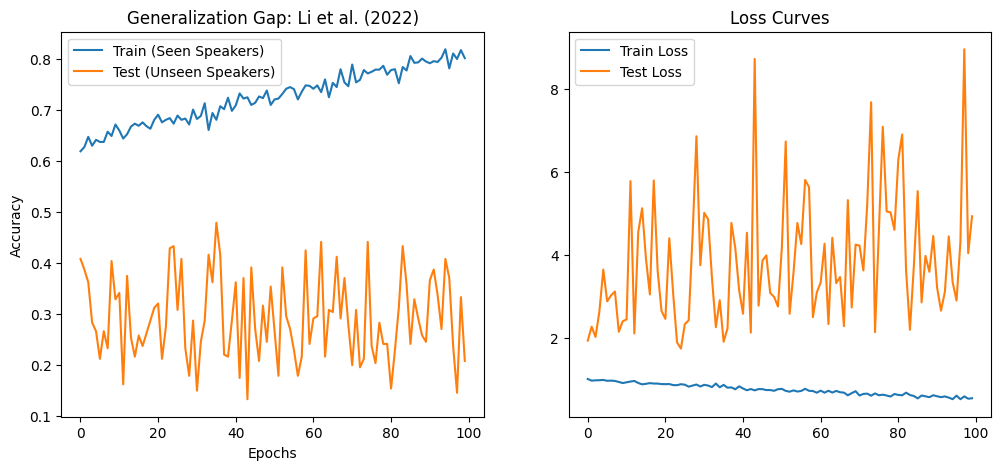

In [ ]:
print("\nStarting Speaker-Independent Training...")
history = model.fit(
    [X_mel_train, X_imel_train], Y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_mel_test, X_imel_test], Y_test), # Testing on Unseen Speakers
    verbose=1
)

# RESULTS
loss, acc = model.evaluate([X_mel_test, X_imel_test], Y_test)

print(f"Strict Split Accuracy (Unseen Spkrs): {acc*100:.2f}%")


# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train (Seen Speakers)')
plt.plot(history.history['val_accuracy'], label='Test (Unseen Speakers)')
plt.title('Generalization Gap: Li et al. (2022)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

**The paper proposes 80% train accuracy which was verified; however, when test train split based on speaker ID is done validation accuracy is low, reaching a max of 33%**